# Evaluating sea ice segmentation

The purpose of the TGRS paper is to describe an approach to evaluating sea ice segmentation drawing on the methods of geographic object-based image analysis (GEOBIA) and traditional segmentation analysis. 

## Goals of image segmentation for sea ice floe identification
The aim of the segmentation is to identify distinct sea ice floes from a scene that may contain multiple heterogeneous ice types, water and land surfaces, and clouds. The resulting objects should have boundaries that match the physical boundary of the ice floe. The physical measurements of the ice floe, including the size, location (centroid), and shape (boundary) are of scientific interest. For example, the momentum exchange between the wind, ice, and ocean depends on the distribution of floe sizes in a scene. Sea ice models use estimates of the floe size distribution properties to parameterize air-ice-ocean coupling. Accurate estimation of the ice floe areas for a representative sample of ice floes is thus important for sea ice model development. Similarly, observational studies of sea ice dynamics, including tracking the dispersion, transport, and evolution of sea ice, rely on measurements of changes in position of individual pieces of ice. Algorithmic approaches to ice floe tracking can use properties of the ice floe size and shape to identify individual ice floes across multiple images. Thus evaluation for sea ice segmentation performance should assess:

- fraction of available floes identified
- skill at locating the correct position of the floe
- skill at identifying the floe boundary
- skill at identifying the floe area

In addition, it is useful to document the contribution of oversegmentation and undersegmentation errors. Both OSE and USE will decrease skill in physical measurements of the objects. 

## Literature review
### Domain-agnostic segmentation evaluation metrics
1. Pixel-wise segmentation evaluation. These methods are simple to apply and are usually based on the confusion matrix. All pixels are assigned a class and thus can be TP, FP, TN, or FN.
2. Object-wise segmentation evaluation. (AKA Object Based Image Analysis (OBIA). In this paradigm, groups of pixels are compared comprising objects, rather than considered individually.
   - Supervised evaluation -- Identifying which objects to compare
   - Unsupervised evaluation -- Examine properties of the object itself







In [13]:
import os
import pandas as pd
import skimage
import numpy as np
import rasterio as rio
from rasterio.plot import reshape_as_image
import proplot as pplt

# Loading images
The code below loads all the true color and manually labeled images into dictionaries.

TBD: Save the segmented images in a format that can be read in here. GeoTiff labeled images would be ideal.

In [51]:
# Load case data
# df = pd.concat([pd.read_csv('../data/validation_tables/' + f) for f in os.listdir('../data/validation_tables/') if '.csv' in f])
df = pd.read_csv('../data/metadata/merged_validation_table.csv', parse_dates=['start_date'], index_col=0)

df['case_number'] = [str(cn).zfill(3) for cn in df['case_number']]
df['start_date'] = pd.to_datetime(df['start_date'].values)
df.index = [cn + '_' + sat for cn, sat in zip(df.case_number, df.satellite)]

def fname(case_data, imtype='labeled'):
    """Generates filenames from rows in the overview table. imtype can be "labeled", "truecolor", 
    or "falsecolor"."""

    cn = case_data['case_number']
    date = pd.to_datetime(case_data['start_date']).strftime('%Y%m%d')
    region = case_data['region']
    sat = case_data['satellite']
    if imtype=='labeled':
        return  '-'.join([cn, region, date, sat, 'labeled_floes.png'])
        
    elif imtype in ['truecolor', 'falsecolor', 'cloudfraction']:
        prefix = '-'.join([cn, region, '100km', date])
        return '.'.join([prefix, sat, imtype, '250m', 'tiff'])
        
# Load images
tc_dataloc = '../data/modis/truecolor/'
cl_dataloc = '../data/modis/cloudfraction/'
lb_dataloc = '../data/validation_images/labeled_floes/'
landmask_dataloc = '../data/validation_images/landmask/'
landfast_dataloc = '../data/validation_images/labeled_landfast/'
ift_lb_dataloc = '../data/ift_lopez-acosta-tiling/labeled_floes/'

tc_images = {}
cl_images = {}
lb_images = {}
ift_lb_images = {}
landmasks = {}
landfast_images = {}

missing = []
for row, data in df.iterrows():
    
    for dataloc, imtype, data_dict in zip([tc_dataloc, cl_dataloc],
                                          ['truecolor', 'cloudfraction'],
                                          [tc_images, cl_images]):
        try:
            with rio.open(dataloc + fname(df.loc[row,:], imtype)) as im:
                data_dict[row] = im.read()
        except:
            print('Couldn\'t read', fname(df.loc[row,:], imtype), imtype)
            if fname(df.loc[row,:], imtype) not in missing:
                missing.append(fname(df.loc[row,:]))

    if data.visible_floes != 'no':
        try:
            with rio.open(lb_dataloc + fname(df.loc[row,:], 'labeled')) as im:
                lb_images[row] = im.read()
        except:
            # print('Couldn\'t read', fname(df.loc[row,:], 'labeled'))
            if fname(df.loc[row,:], imtype) not in missing:
                missing.append(fname(df.loc[row,:]))        
        try:
            with rio.open(ift_lb_dataloc + fname(df.loc[row,:], 'labeled').replace('png', 'tiff')) as im:
                ift_lb_images[row] = im.read()
        except:
            pass
    try:
        with rio.open(landmask_dataloc + fname(df.loc[row,:], 'labeled').replace('labeled_floes', 'landmask')) as im:
            landmasks[row] = im.read()
    except:
        pass            
    try:
        with rio.open(landfast_dataloc + fname(df.loc[row,:], 'labeled').replace('labeled_floes', 'labeled_landfast')) as im:
            landfast_images[row] = im.read()
    except:
        pass                    

/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [15]:
fname(df.loc[row,:], 'labeled')

'189-sea_of_okhostk-20120426-terra-labeled_floes.png'

In [27]:
processed = list(ift_lb_images.keys())
processed.sort()

In [47]:
[x for x in np.array(['LB', 'LM', 'LF'])[lb, lm, lf]]

[array(['LB', 'LM', 'LF'], dtype='<U2')]

In [52]:

for case in processed:
    if case in lb_images:
        lb = False
        lm = False
        lf = False
        if lb_images[case].shape[1] != 400:
            lb = True
        if case in landmasks:
            if landmasks[case].shape[1] != 400:
                lm = True
        if case in landfast_images:
            if landfast_images[case].shape[1] != 400:
                lf = True
            
        if np.any([lb, lm, lf]):
            print(case, lb, lm, lf)

029_aqua True True True
029_terra True True True
036_aqua True True True
046_terra False False True
075_aqua True True True
075_terra True True True
115_aqua True False False
116_aqua True True False
116_terra True True False
118_aqua True True True
118_terra True True True
119_aqua True True True
119_terra True True True
121_aqua True True True
121_terra True True True
138_aqua True True True
138_terra True True True
141_aqua True True True
141_terra True True True
144_aqua True True True
144_terra True True True
150_aqua True True True
150_terra True True True
152_aqua True True True
152_terra True True True
156_aqua True True True
156_terra True True True
157_aqua True True True
157_terra True True True
186_aqua True True False
188_aqua True False False
188_terra True True True


In [17]:
for case in processed:
    
    fig, ax = pplt.subplots(nrows=1, ncols=2, width=7)
    ax[0].imshow(reshape_as_image(tc_images[case]))
    if case in lb_images:
        manual_floe_labels = np.ma.masked_array(lb_images[case][0,:,:], mask=lb_images[case][0,:,:]==0)
        ax[0].pcolormesh(manual_floe_labels, color='b', alpha=0.5)
        ax[1].pcolormesh(manual_floe_labels, color='b', alpha=0.5)
    if case in ift_lb_images:
        ift_floe_labels = np.ma.masked_array(ift_lb_images[case][0,:,:], mask=ift_lb_images[case][0,:,:]==0)
        ax[0].pcolormesh(ift_floe_labels, color='r', alpha=0.5)        
        ax[1].pcolormesh(ift_floe_labels, color='r', alpha=0.5)

    try:
        landmask = np.ma.masked_array(landmasks[case][0,:,:], mask=landmasks[case][0,:,:]==0)
        landfast = np.ma.masked_array(landfast_images[case][0,:,:], mask=landfast_images[case][0,:,:]==0)
        if ~np.any(landmask > 0):
            landmask = landmask*0
        
        ax[1].pcolormesh(landmask, color='k', alpha=0.5)
        ax[1].pcolormesh(landfast, color='gold', alpha=0.5)
    except:
        print('Couldn\'t plot landmask/landfast for', case)
    ax.format(yreverse=True, title=case)

    for color, label in zip(['b', 'r', 'k', 'gold'], ['manual', 'ift', 'land', 'landfast']):
        ax[0].plot([],[],m='s', lw=0, color=color, alpha=0.75, label=label)
    fig.legend(loc='b', ncols=2, alpha=0.9)

    fig.save('../figures/ift_lopez-acosta-tiling/' + case + '_overlay.png', dpi=300)
    pplt.close(fig)

/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/si

Couldn't plot landmask/landfast for 006_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 006_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 007_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 007_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 010_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 010_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 011_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 011_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 013_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 013_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 014_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 014_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 016_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 016_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 017_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 017_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 018_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 018_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 019_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 019_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 020_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 020_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 022_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 022_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 025_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 025_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 028_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 028_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 034_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 034_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 036_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 037_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 037_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 039_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 039_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 040_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 040_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 041_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 041_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 042_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 042_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 044_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 044_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 047_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 047_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 049_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 049_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 050_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 050_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 051_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 051_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 052_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 052_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 053_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 053_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 054_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 054_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 055_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 055_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 057_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 057_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 058_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 058_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 059_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 059_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 061_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 061_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 064_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 064_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 065_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 065_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 067_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 067_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 069_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 069_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 070_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 073_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 073_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 074_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 074_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 077_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 077_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 078_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 078_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 079_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 079_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 080_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 080_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 081_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 081_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 082_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 082_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 084_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 084_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 086_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 087_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 088_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 088_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 090_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 090_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 095_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 095_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 097_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 097_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 100_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 100_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 101_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 101_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 102_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 102_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 103_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 104_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 104_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 105_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 105_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 106_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 106_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 107_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 107_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 110_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 110_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 111_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 111_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 112_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 112_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 113_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 113_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 115_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 115_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 116_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 116_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 117_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 117_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 118_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 118_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 119_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 119_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 120_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 120_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 121_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 121_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 122_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 122_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 124_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 125_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 127_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 127_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 128_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 128_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 129_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 129_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 130_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 130_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 131_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 131_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 132_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 132_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 133_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 133_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 136_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 136_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 137_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 137_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 139_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 139_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 140_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 140_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 142_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 142_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 146_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 146_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 147_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 147_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 148_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 148_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 152_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 152_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 153_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 154_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 154_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 155_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 155_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 156_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 156_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 157_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 157_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 158_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 158_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 159_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 159_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 160_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 160_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 161_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 161_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 162_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 162_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 163_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 163_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 164_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 164_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 165_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 165_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 166_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 166_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 169_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 169_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 171_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 171_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 175_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 175_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 178_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 178_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 186_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 188_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 189_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 189_terra


# Object-based evaluation

In order to consider the quality of segmented objects against a reference dataset, we need to first be able to link image segments to ground truth, in other words identify true positives. Considering a set of predicted segments $\hat S$ and a ground truth set $S$, we wish to find a map linking $\hat s \in \hat S$ to $s \in S$.

In Simon's code, the primary matching metric is the intersection over union (the Jaccard index). Letting $|A|$ be the area covered by a set $A$, then the intersection over union of $A$ and $B$ is
$$J(A,B) = \frac{|A \cap B|}{|A \cup B|}$$
This is a reasonable, intuitive measure. Where we ran into an issue is the idea that in the literature (references?) a cutoff of $J(A,B)>0.5$ to count as a true positive. 

For a true floe $s$, we define the set of _candidate objects_ as the set $\hat s \in S$ such that $J(\hat s, s) > 0$. 
_Oversegmentation error_ (OSE) is indicated by the presence of multiple candidate objects. Similarly, _undersegmentation error_ is defined by the opposite relation: a single candidate object in $\hat S$ matching to multiple true floes in $S$.

There are some challenges with $J$ as a metric. Since it depends on the area of shapes, the sensitivity of the metric will vary with floe size. Suppose an object is composed of 4 pixels each with area 1. A segmentation algorithm produces an object that is off by one pixels. The Jaccard index will then be 0.75 if the pixels are maximally aligned. An offset by 1 pixel to the side would produce J=0.3, and 1 down and 1 over would be J=0.14. 

* The minimum object size should depend on the number of pixels, and this minimum should account for the sensitivity of the metric.

The Jaccard index dates to the 19th century, and since then, strengths and weaknesses of the method have been often described in the literature.


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


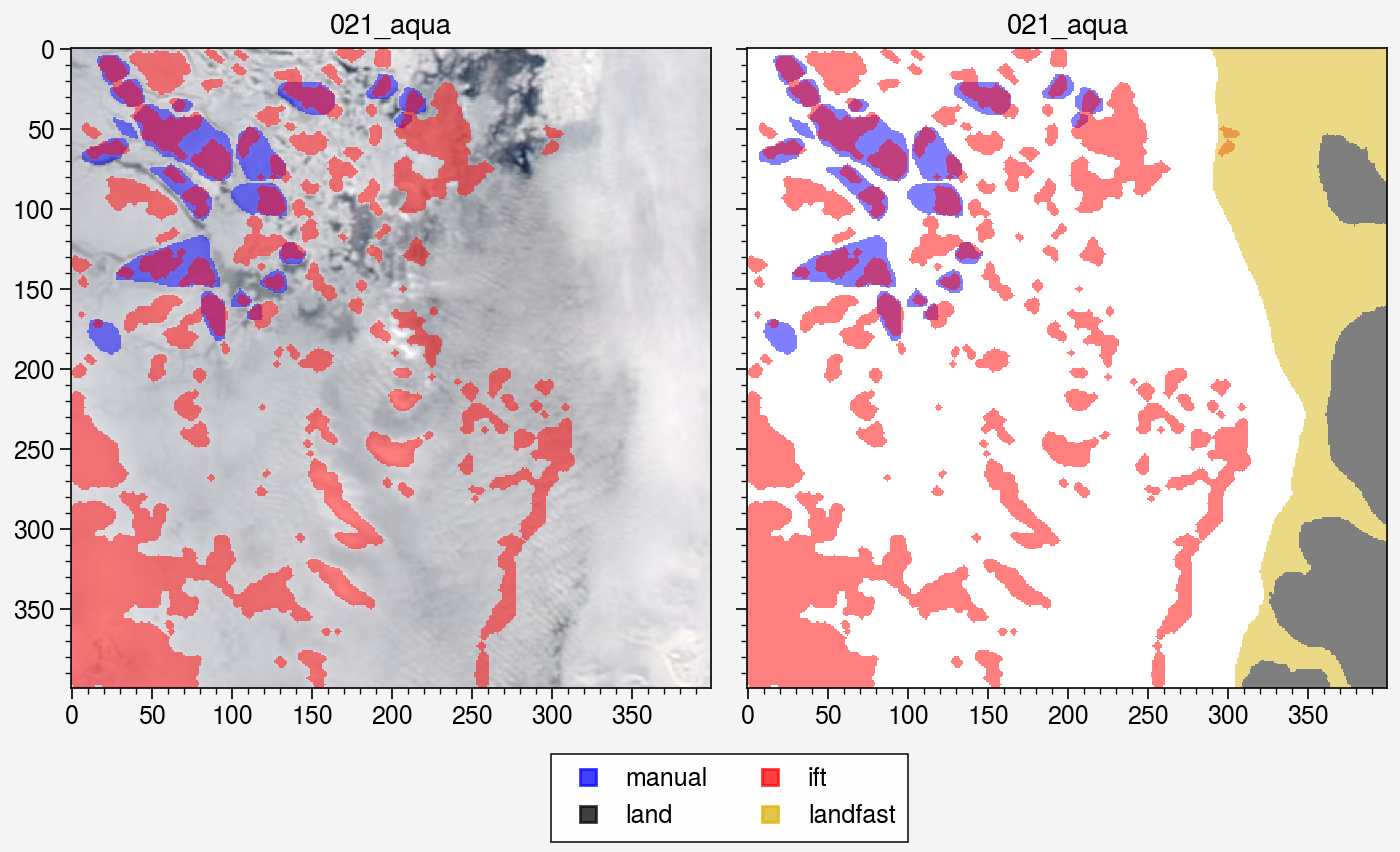

In [65]:
case = '021_aqua'
fig, ax = pplt.subplots(nrows=1, ncols=2, width=7)
ax[0].imshow(reshape_as_image(tc_images[case]))
if case in lb_images:
    manual_floe_labels = np.ma.masked_array(lb_images[case][0,:,:], mask=lb_images[case][0,:,:]==0)
    ax[0].pcolormesh(manual_floe_labels, color='b', alpha=0.5)
    ax[1].pcolormesh(manual_floe_labels, color='b', alpha=0.5)
if case in ift_lb_images:
    ift_floe_labels = np.ma.masked_array(ift_lb_images[case][0,:,:], mask=ift_lb_images[case][0,:,:]==0)
    ax[0].pcolormesh(ift_floe_labels, color='r', alpha=0.5)        
    ax[1].pcolormesh(ift_floe_labels, color='r', alpha=0.5)

try:
    landmask = np.ma.masked_array(landmasks[case][0,:,:], mask=landmasks[case][0,:,:]==0)
    landfast = np.ma.masked_array(landfast_images[case][0,:,:], mask=landfast_images[case][0,:,:]==0)
    if ~np.any(landmask > 0):
        landmask = landmask*0
    
    ax[1].pcolormesh(landmask, color='k', alpha=0.5)
    ax[1].pcolormesh(landfast, color='gold', alpha=0.5)
except:
    print('Couldn\'t plot landmask/landfast for', case)
ax.format(yreverse=True, title=case)

for color, label in zip(['b', 'r', 'k', 'gold'], ['manual', 'ift', 'land', 'landfast']):
    ax[0].plot([],[],m='s', lw=0, color=color, alpha=0.75, label=label)
fig.legend(loc='b', ncols=2, alpha=0.9)


# Adapting the object-based analysis from Simon's code to process this image
- Determining the "Relevant Set" for each of the ground truth floes.

0.25919175001264155

In [55]:
[x for x in lb_images.keys() if x in ift_lb_images]

['001_aqua',
 '001_terra',
 '004_aqua',
 '004_terra',
 '005_aqua',
 '005_terra',
 '006_aqua',
 '006_terra',
 '008_aqua',
 '008_terra',
 '009_aqua',
 '009_terra',
 '010_aqua',
 '010_terra',
 '012_aqua',
 '012_terra',
 '015_aqua',
 '015_terra',
 '016_aqua',
 '016_terra',
 '019_aqua',
 '019_terra',
 '021_aqua',
 '021_terra',
 '029_aqua',
 '029_terra',
 '036_aqua',
 '046_aqua',
 '046_terra',
 '048_aqua',
 '048_terra',
 '051_aqua',
 '051_terra',
 '056_aqua',
 '056_terra',
 '062_aqua',
 '062_terra',
 '075_aqua',
 '075_terra',
 '081_aqua',
 '081_terra',
 '093_aqua',
 '093_terra',
 '100_aqua',
 '100_terra',
 '103_aqua',
 '108_aqua',
 '108_terra',
 '109_aqua',
 '109_terra',
 '110_aqua',
 '110_terra',
 '115_aqua',
 '115_terra',
 '116_aqua',
 '116_terra',
 '118_aqua',
 '118_terra',
 '119_aqua',
 '119_terra',
 '121_aqua',
 '121_terra',
 '138_aqua',
 '138_terra',
 '141_aqua',
 '141_terra',
 '144_aqua',
 '144_terra',
 '150_aqua',
 '150_terra',
 '152_aqua',
 '152_terra',
 '156_aqua',
 '156_terra',
 '

In [66]:
import skimage
results = []

def distance(p1, p2):
    return np.round(np.sqrt((p1[0] - p2[0])**2 + (p1[0] - p2[1])**2), 2)
    
for case in ['021_aqua']:
    
    man_img = skimage.measure.label(lb_images[case][0,:,:])
    ift_img = ift_lb_images[case][0,:,:] # assumes it's labeled. If not, would need to label it.
    tc_img = tc_images[case]
    land_mask_img = landfast_images[case]
    
    # get the labels from the manual image
    man_img_props = skimage.measure.regionprops(man_img)
    ift_img_props = skimage.measure.regionprops(ift_img)
    man_img_props = {floe.label: floe for floe in man_img_props}
    ift_img_props = {floe.label: floe for floe in ift_img_props}
    # simple true positive: only one IFT label intersects with the manual label and vice versa
    # simple oversegmentation: multiple IFT labels with one manual label
    # simple undersegmentation: single IFT label with multiple manual label
    
    matches = []
    for floe_id in man_img_props:
        # List of IFT floes with nonzero overlap to manual
        ift_matches_manual = np.unique(ift_img[man_img == floe_id])
    
        # List of manual floes with nonzero overlap to the selected IFT floes
        for ift_floe_id in ift_matches_manual:
            if ift_floe_id > 0:
                matches.append([floe_id, ift_floe_id])
    
    match_df = pd.DataFrame(matches, columns=['manual_id', 'ift_id'])
    ift_dupes_df = match_df.loc[match_df.duplicated(subset='ift_id', keep=False)]
    match_df = match_df.loc[~match_df.duplicated(subset='ift_id', keep=False), ]
    
    for row, data in match_df.iterrows():
        underestimate = (man_img == data.manual_id) & (ift_img != data.ift_id)
        overestimate = (man_img != data.manual_id) & (ift_img == data.ift_id)
        a_cap_b = (man_img == data.manual_id) & (ift_img == data.ift_id)
        a_cup_b = (man_img == data.manual_id) | (ift_img == data.ift_id)
    
        match_df.loc[row, 'jaccard_index'] = np.round(np.sum(a_cap_b)/np.sum(a_cup_b), 2)
        match_df.loc[row, 'edge_error'] = np.sum(underestimate | overestimate)
        match_df.loc[row, 'underestimate_error'] = np.sum(underestimate)
        match_df.loc[row, 'overestimate_error'] = np.sum(overestimate)
        match_df.loc[row, 'area'] = np.round(man_img_props[data.manual_id].area, 2)
        match_df.loc[row, 'perimeter'] = np.round(man_img_props[data.manual_id].perimeter, 2)
        match_df.loc[row, 'centeroid_error'] = distance(man_img_props[data.manual_id].centroid, ift_img_props[data.ift_id].centroid)
        match_df.loc[row, 'area_error'] = np.round(ift_img_props[data.ift_id].area - man_img_props[data.manual_id].area, 2)
        match_df.loc[row, 'perimeter_error'] = np.round(ift_img_props[data.ift_id].perimeter - man_img_props[data.manual_id].perimeter, 2)
    results.append(match_df)

In [ ]:
def select_relevant_set(label_i, gt_image, seg_image, thresh=0.5):
    """Identifies the set of labels in the segmented image corresponding
    to the "Relevant Set". Mutual centroid inclusion, or relative overlap of 50 percent."""

    possible = np.unique(seg_image[gt_image == label_i])
    if len(possible) == 0:
        return
    elif len(possible) == 1:
        # check

In [58]:
pd.DataFrame({'Rel. Edge Error': (match_df['edge_error'])/match_df['area'],
                     'Rel. Ovrst Error': (match_df['overestimate_error'])/match_df['area'],
                     'Rel. Undrst Error': (match_df['underestimate_error'])/match_df['area']})

,Rel. Edge Error,Rel. Ovrst Error,Rel. Undrst Error
0,3.942623,3.713115,0.229508
1,0.705573,0.013670,0.691903
2,0.657895,0.000000,0.657895
3,2.308989,2.258427,0.050562
4,0.355670,0.025773,0.329897
5,0.686275,0.019608,0.666667
6,0.518519,0.092593,0.425926
7,1.184713,0.770701,0.414013


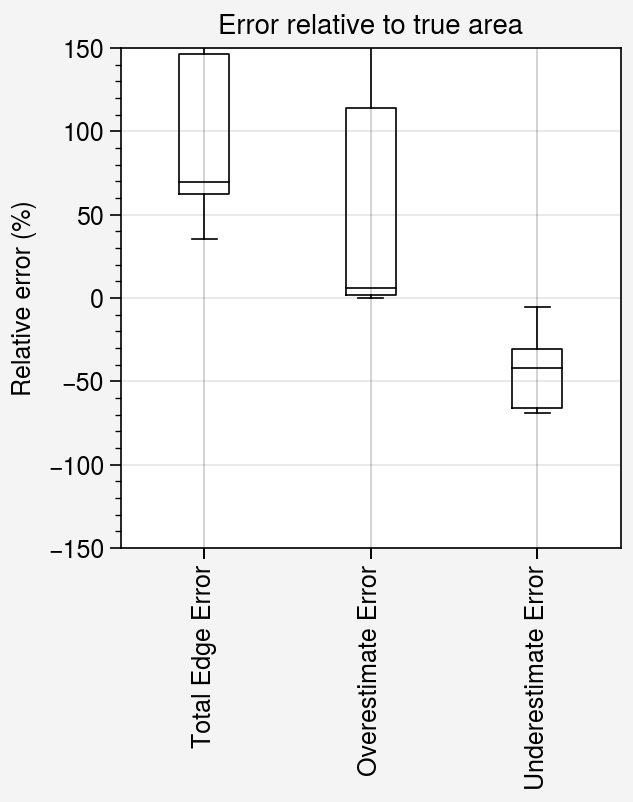

In [59]:
match_df = pd.concat(results).reset_index(drop=True)
fig, ax = pplt.subplots()
ax.box(100*pd.DataFrame({'Total Edge Error': (match_df['edge_error'])/match_df['area'],
                     'Overestimate Error': (match_df['overestimate_error'])/match_df['area'],
                     'Underestimate Error': -(match_df['underestimate_error'])/match_df['area']}))
ax.format(ylim=(-150, 150), title='Error relative to true area', xrotation=90, ylabel='Relative error (%)')

/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


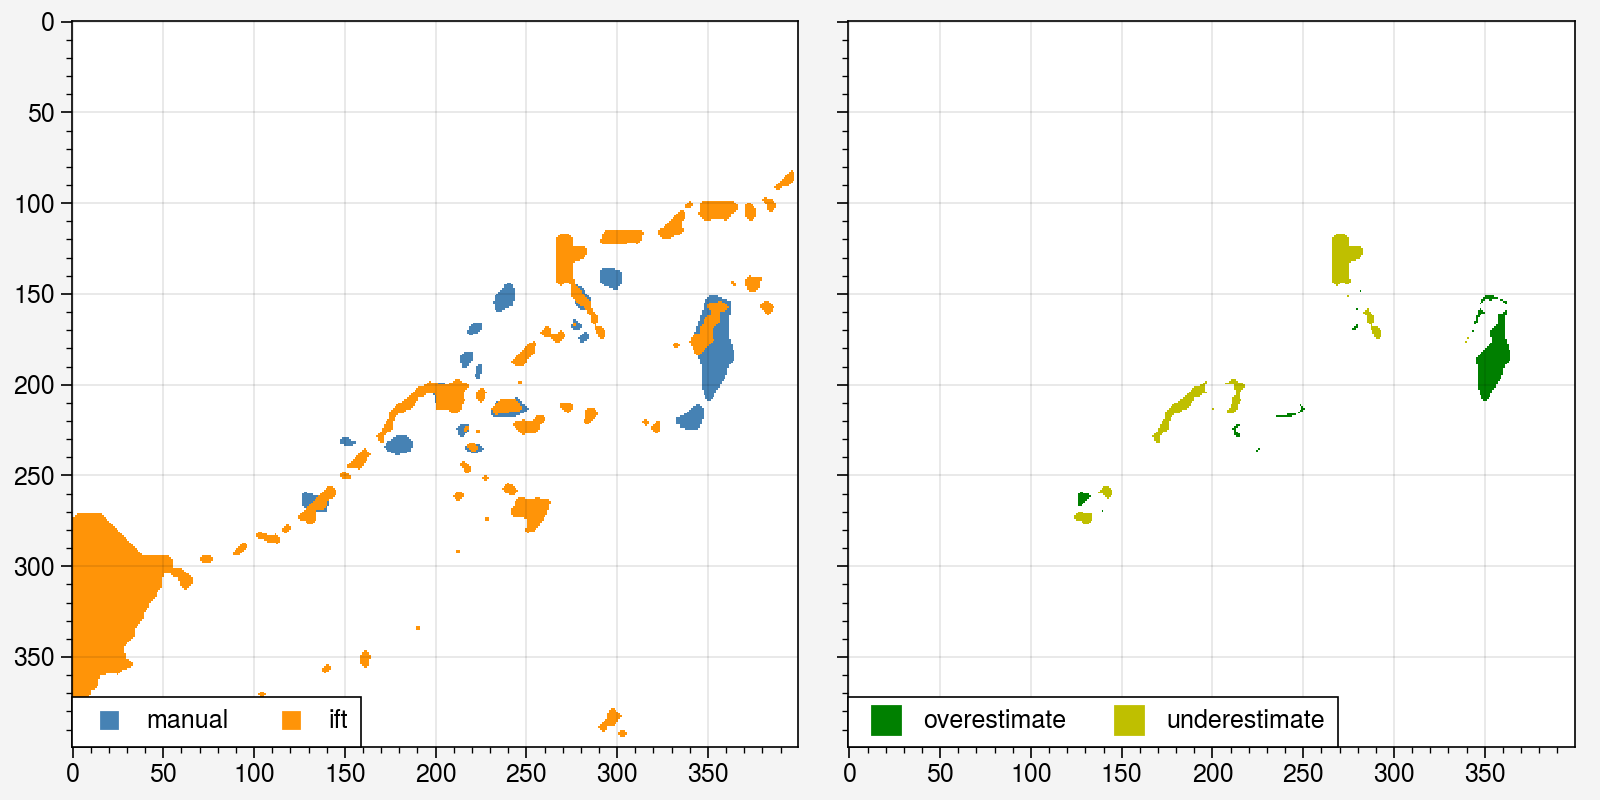

In [60]:
# over/underestimation from Goessling et al. 206 adapted to floe-by-floe
fig, axs = pplt.subplots(width=8, height=4, ncols=2)
axs[0].imshow(np.ma.masked_array(man_img, mask=man_img == 0), color='steelblue', alpha=1)
axs[0].imshow(np.ma.masked_array(ift_img, mask=ift_img == 0), color='tangerine', alpha=1)

for row, data in match_df.iterrows():
    man_floe_id = data.manual_id
    ift_floe_id = data.ift_id
    edge_error = ((man_img == man_floe_id) & (ift_img != ift_floe_id)) | ((man_img != 108) & (ift_img == 24))
    underestimate = (man_img == man_floe_id) & (ift_img != ift_floe_id)
    overestimate = (man_img != man_floe_id) & (ift_img == ift_floe_id)
    axs[1].imshow(np.ma.masked_array(edge_error > 0, mask=~underestimate), color='g', alpha=1)
    axs[1].imshow(np.ma.masked_array(edge_error > 0, mask=~overestimate), color='y', alpha=1)

for color, label in zip(['steelblue', 'tangerine'], ['manual', 'ift']):
    axs[0].plot([],[],m='s', lw=0, color=color, alpha=1, label=label)
axs[0].legend(loc='ll', ncols=2, alpha=1)    
for color, label in zip(['green', 'y'], ['overestimate', 'underestimate']):
    axs[1].plot([],[],m='s', lw=0, color=color, alpha=1, label=label)
axs[1].legend(loc='ll', ncols=2, alpha=1, ms=10)    

/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


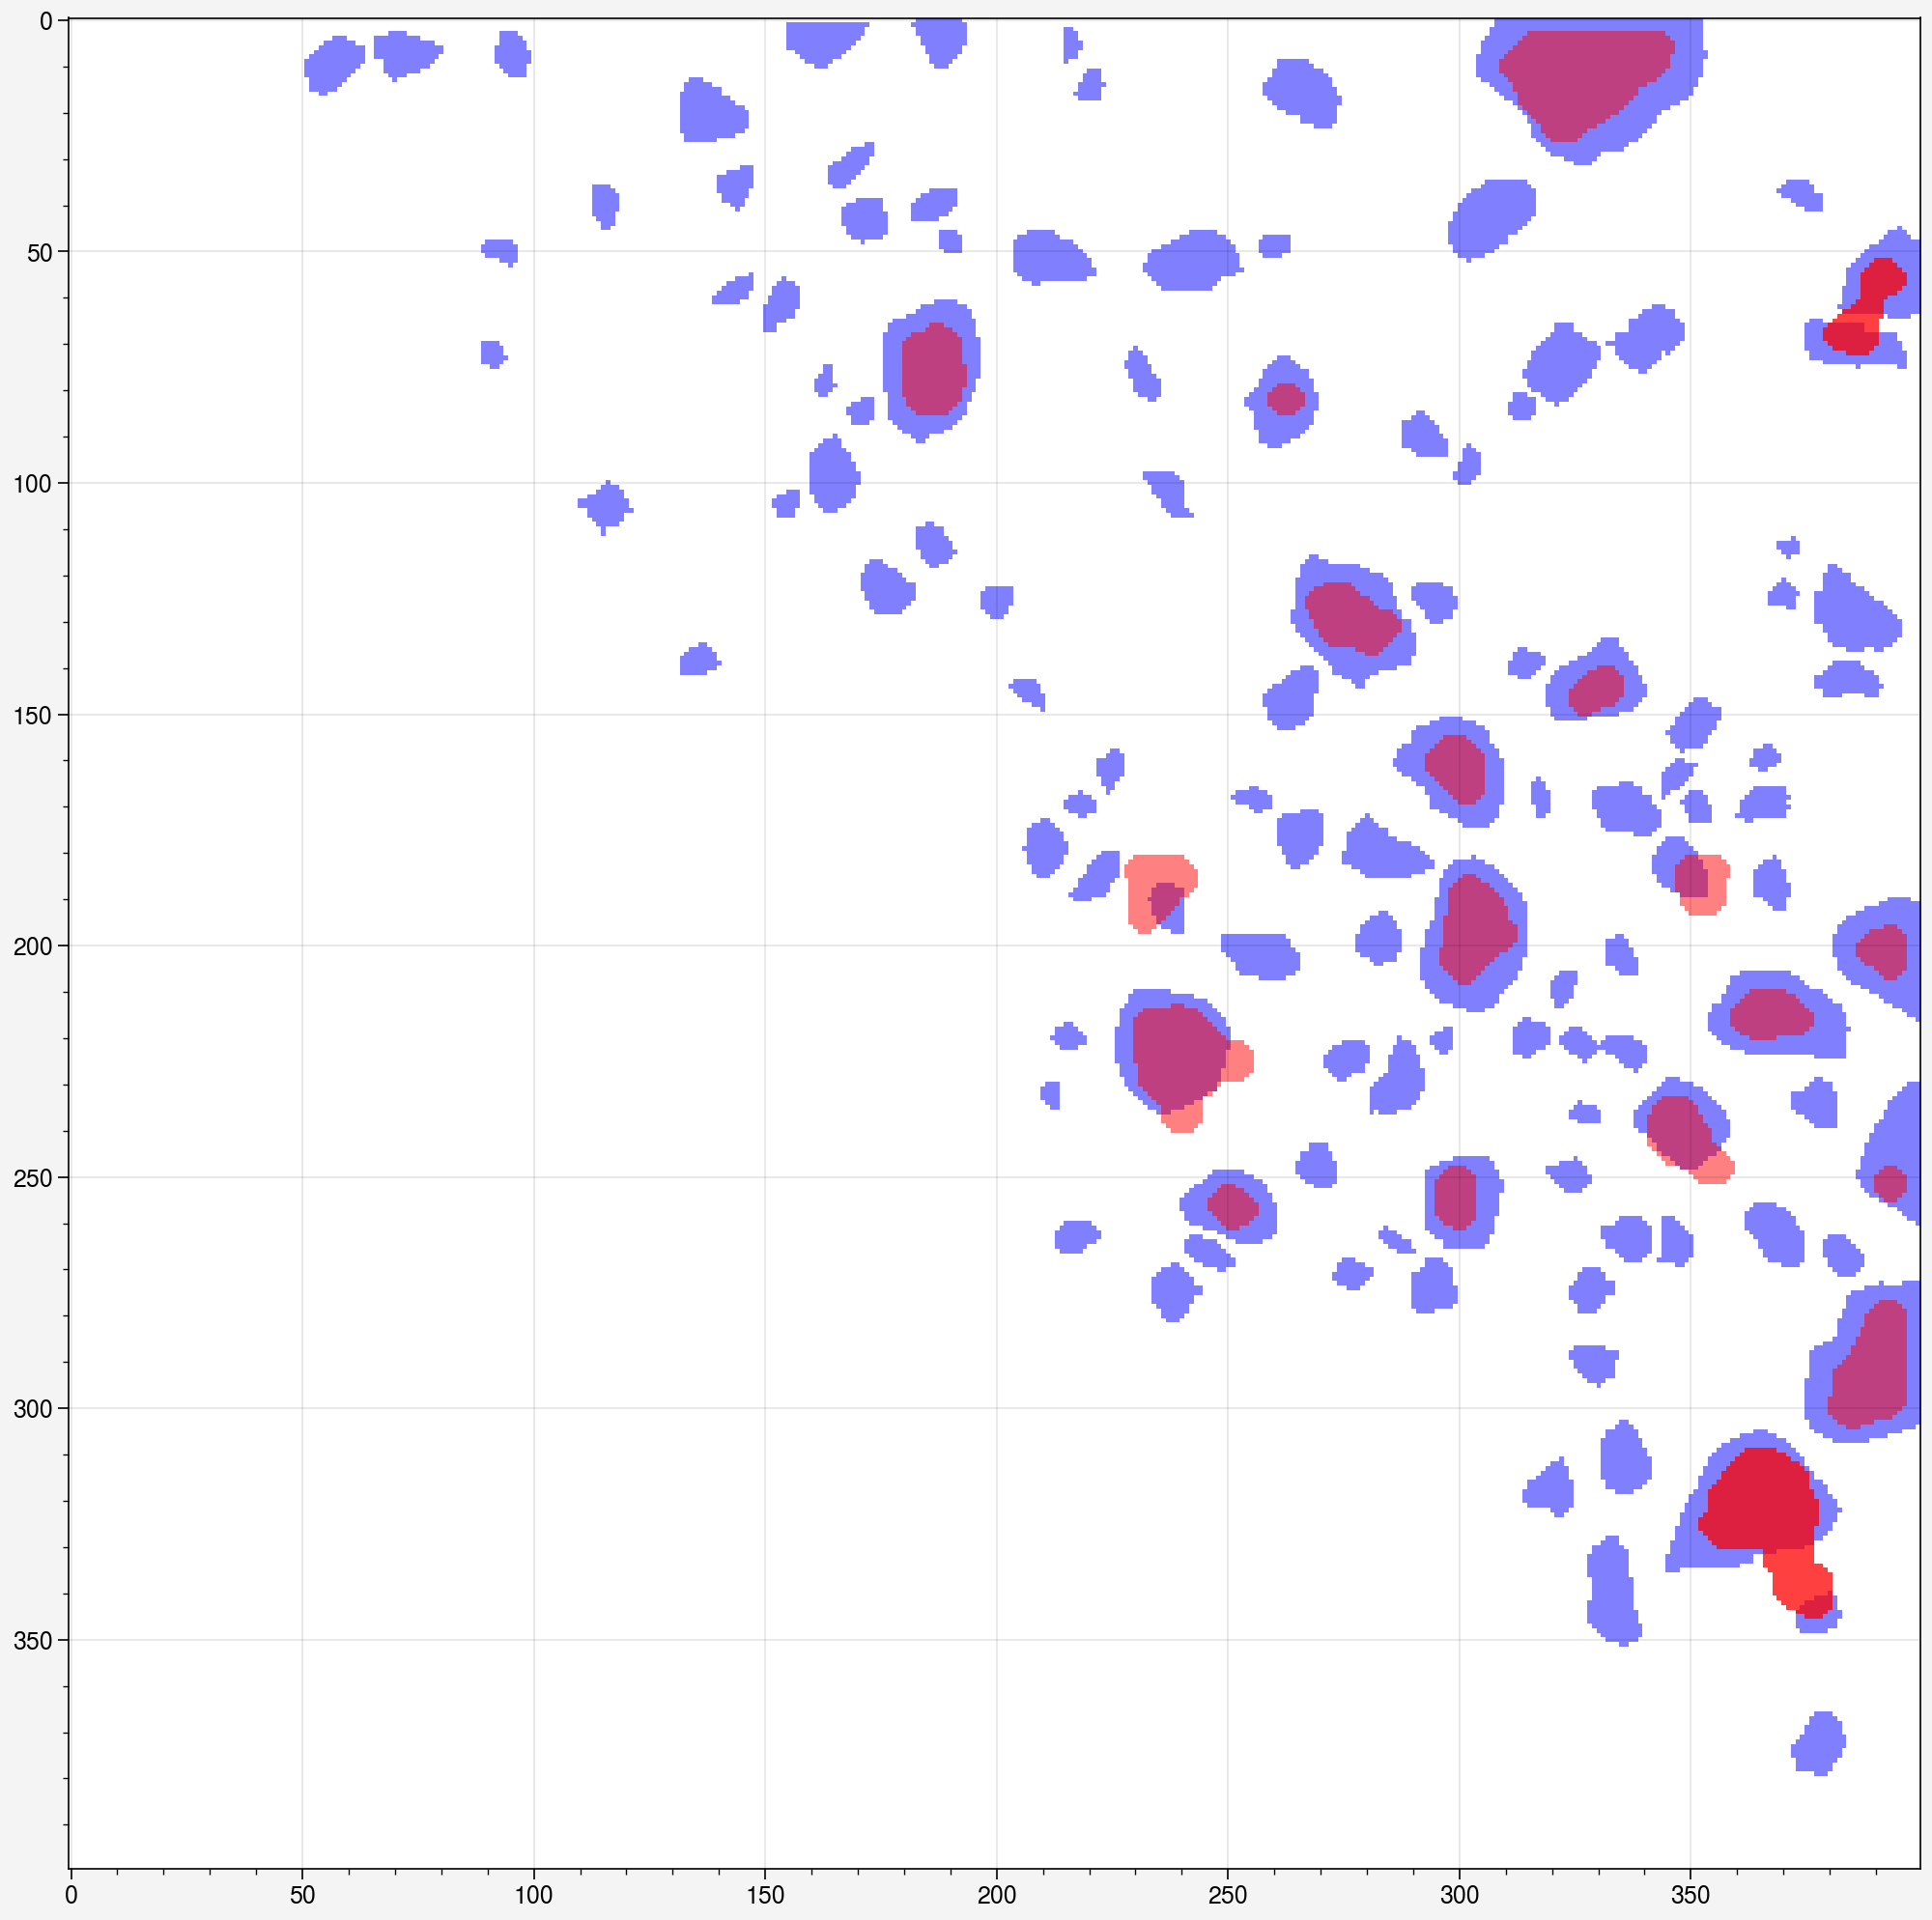

In [191]:
fig, ax = pplt.subplots(width=10)
ax.imshow(np.ma.masked_array(man_img, mask=man_img == 0), color='b', alpha=0.5)
for floe_id in man_img_props:
    
    matches = np.unique(ift_img[man_img == floe_id])
    if np.any(matches > 0):
        if len(matches[matches != 0]) == 1:
            ift_floe_id = matches[matches != 0][0]
            ax.imshow(np.ma.masked_array(ift_img, mask=ift_img != ift_floe_id), color='r', alpha=0.5)

In [157]:
from skimage.metrics import adapted_rand_error, variation_of_information
error, precision, recall = adapted_rand_error(man_img, ift_img)
error, precision, recall

(0.9628331935985566, 0.6345415265067076, 0.019144062864835002)

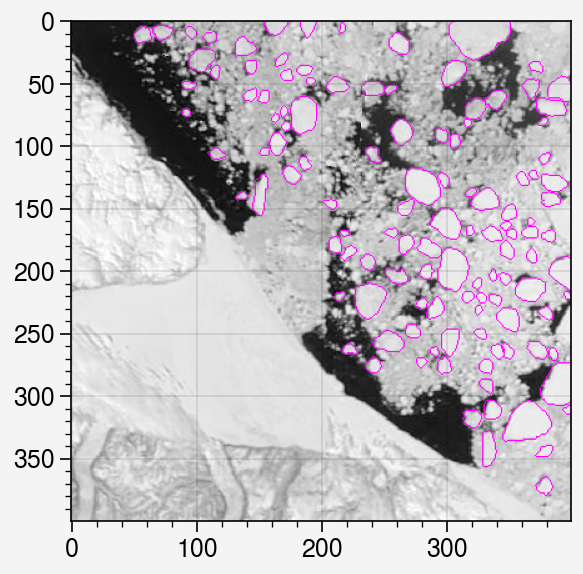

In [155]:
from skimage.segmentation import mark_boundaries
fig, ax = pplt.subplots()
ax.imshow(mark_boundaries(tc_images[case][0,:,:], man_img, color=(1, 0, 1)))

In [ ]:
import cv2
from copy import deepcopy
import numpy as np
import h5py
import sys
from pandas import Series
from filter_function import ift_filter

IOU_THRESHOLD = 0.5

    # Manual image loading
    raw_manual_img = cv2.imread(manual_path)
    manual_img = np.zeros((len(raw_manual_img), len(raw_manual_img[0])))
    idx = raw_manual_img[:,:,0] > 0
    manual_img[idx] = 255

    # Get individual manual floes
    man_num_labels, man_labels, man_stats, man_centroids = cv2.connectedComponentsWithStats(
                                                            manual_img.astype('uint8'), connectivity=8)

    ift_to_manual_floes = {}
    false_positives = []

    # Assume a floe is a false positive until we find an IFT one that corresponds
    false_negatives = list(range(1, man_num_labels))

    # Get IFT overlaps with real floes
    for i in range(1, ift_num_labels):

        # Get indices of points in ift image corresponding to floes
        idx = ift_labels[:,:] == i

        # Check if this floe intersects the landmask
        landmask_intersection = np.logical_and(idx, idx_landmass)

        # If it does, skip this floe for the purposes of calculation
        if np.sum(landmask_intersection) > 0:
            continue

        # Get manual floes in that area.
        manual_area = man_labels[idx]

        # Get the unique numbers of manual floes in that area.
        overlapping_manual = list(set(manual_area))

        # Add to dict based on result
        # If no overlapping real floes, false positive IFT result.
        if len(overlapping_manual) == 1 and overlapping_manual[0] == 0:
            false_positives.append(i)
        
        # Otherwise, add index of real manual floes to dictionary.
        else:
            if 0 in overlapping_manual:
                overlapping_manual.remove(0)
            ift_to_manual_floes[int(i)] = overlapping_manual

            # Remove false negatives
            for floe in overlapping_manual:
                if floe in false_negatives:
                    false_negatives.remove(floe)


    # Can consider the similarity of the floe pairings in the dictionary
    for key, value in ift_to_manual_floes.items():

        # Create list for all real floes matching this predicted floe.
        new_val = []


        # Generate countours of this floe for boundary iou and dilate
        floe_img_idx = ift_labels[:,:] == key
        binary_img = np.zeros_like(floe_img_idx, dtype=np.uint8)
        binary_img[floe_img_idx] = 255
        contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contour_img = np.zeros_like(binary_img)
        cv2.drawContours(contour_img, contours, 0, (255))
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
        dilated_predicted_boundary = cv2.dilate(contour_img, kernel, iterations=1)

        dilated_pred_boundary_idx = np.logical_and(dilated_predicted_boundary[:,:] > 0, ift_labels[:,:] != key)
        dilated_predicted_boundary = np.zeros_like(dilated_pred_boundary_idx, dtype=np.uint8)
        dilated_predicted_boundary[dilated_pred_boundary_idx] = 255

        # Get dilated area
        dilated_predicted_area = np.sum(dilated_predicted_boundary[:,:] == 255)
        
        
        for real_floe in value:


            intersection_stats = {}

            intersection_idx = np.logical_and(ift_labels[:,:] == key, man_labels[:,:] == real_floe)

            intersection_area = np.sum(intersection_idx)

            iou = intersection_area / (man_stats[real_floe][4] + ift_stats[key][4] - intersection_area)

            centroid_distance_px = np.sqrt((man_centroids[real_floe][0] - ift_centroids[key][0])**2 + 
                                (man_centroids[real_floe][1] - ift_centroids[key][1])**2)


            # Get dilated real floe boundary
            floe_img_idx = man_labels[:,:] == real_floe
            binary_img = np.zeros_like(floe_img_idx, dtype=np.uint8)
            binary_img[floe_img_idx] = 255
            contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            contour_img = np.zeros_like(binary_img)
            cv2.drawContours(contour_img, contours, 0, (255))
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
            dilated_real_boundary = cv2.dilate(contour_img, kernel, iterations=1)


            dilated_real_boundary_idx = np.logical_and(dilated_real_boundary[:,:] > 0, man_labels[:,:] == real_floe)
            dilated_real_boundary = np.zeros_like(dilated_real_boundary_idx, dtype=np.uint8)
            dilated_real_boundary[dilated_real_boundary_idx] = 255

            dilated_real_area = np.sum(dilated_real_boundary[:,:] == 255)


            # Calculate boundary iou
            intersection_idx = np.logical_and(dilated_real_boundary[:,:] == 255, dilated_predicted_boundary[:,:] == 255)
            bound_intersection_area = np.sum(intersection_idx)
            boundary_iou = bound_intersection_area / (dilated_real_area + dilated_predicted_area - bound_intersection_area)

            intersection_stats['area_percent_difference'] = (ift_stats[key][4] - man_stats[real_floe][4]) / man_stats[real_floe][4]
            intersection_stats['real_floe'] = int(real_floe)
            intersection_stats['iou'] = iou
            intersection_stats['centroid_distance'] = centroid_distance_px
            intersection_stats['boundary_iou'] = boundary_iou
            new_val.append(intersection_stats)

        ift_to_manual_floes[key] = new_val

    # Copy intersection stats for later
    intersections = deepcopy(ift_to_manual_floes)


    # Non-max suppression
    # Takes care of undersegmentation errors
    for ift, reals in ift_to_manual_floes.items():

        # Gets index of best matching real floe for IFT floe
        possible_match_idx = max(enumerate(reals), key=lambda x: x[1]['iou'])[0]
        
        # Removes best matching from list of IFT floes
        possible_match = reals.pop(possible_match_idx)

        # Adds remainder of floes (besides best match) to false negative list
        for non_match in reals:
            real_floe_number = non_match['real_floe']
            false_negatives.append({'floe_number': real_floe_number, 
                                    'floe_area': int(man_stats[real_floe_number][4]), 
                                    'overlap': True})

        # Sets ift_to_manual key to remaining best match
        ift_to_manual_floes[ift] = possible_match



    # Pair predicted floes to their best predictions
    # Takes care of oversegmentation errors
    to_remove = set()
    for ift1, real1 in ift_to_manual_floes.items():

        for ift2, real2 in ift_to_manual_floes.items():

            if ift1 != ift2 and real1['real_floe'] == real2['real_floe'] and real1['iou'] > real2['iou']:
                to_remove.add(ift2)

    
    for idx in list(to_remove):
        false_positives.append({'floe_number': idx, 
                                    'floe_area': int(ift_stats[idx][4]), 'overlap': True})
        del ift_to_manual_floes[idx]

    """
    After NMS, we have a list of FN and FP floes and a dict with predictions as keys and
    best matching real floes as values. Other real floes have been discarded as FNs.
    After NMS, the next step is determining whether the remaining pairings are good pairings.
    """

    to_remove = []
    for ift, real in ift_to_manual_floes.items():
        if real['boundary_iou'] < IOU_THRESHOLD and real['iou'] < IOU_THRESHOLD:
            to_remove.append(ift)

    for idx in to_remove:
        false_positives.append({'floe_number': idx, 
                                'floe_area': int(ift_stats[idx][4]), 'overlap': True})
        real_floe_number = ift_to_manual_floes[idx]['real_floe']
        false_negatives.append({'floe_number': real_floe_number, 
                                'floe_area': int(man_stats[real_floe_number][4]), 'overlap': True})
        del ift_to_manual_floes[idx]

    # Modify false positives to include floe information
    for i in range(len(false_positives)):
        if isinstance(false_positives[i], dict):
            continue
        else:
            floe_number = false_positives[i]
            floe_dict = {}
            floe_dict['floe_number'] = int(floe_number)
            floe_dict['floe_area'] = int(ift_stats[floe_number][4])
            floe_dict['overlap'] = False
            false_positives[i] = floe_dict

        
    # Modify false negatives to include floe information
    for i in range(len(false_negatives)):
        if isinstance(false_negatives[i], dict):
            continue
        else:
            floe_number = false_negatives[i]
            floe_dict = {}
            floe_dict['floe_number'] = int(floe_number)
            floe_dict['floe_area'] = int(man_stats[floe_number][4])
            floe_dict['overlap'] = False
            false_negatives[i] = floe_dict

    floe_conf_matrix = {'t_pos_floes': len(ift_to_manual_floes), 'f_pos_floes': len(false_positives), 
                        'f_neg_floes': len(false_negatives), 't_neg_floes': 1}


    ift_to_manual_tp = {}
    for k, v in ift_to_manual_floes.items():
        ift_to_manual_tp[k] = {'real_floe': v['real_floe'], 'real_floe_area': int(man_stats[v['real_floe']][4]),
                                'ift_floe_area': int(ift_stats[k][4])}

    if threshold_params:
        props['TP'] = ''
        props['ift_path'] = ift_path

        for open, labeled in open_to_labeled_map.items():
            props.loc[props['label'] == labeled, 'TP'] = (open in ift_to_manual_tp.keys())

    return floe_conf_matrix, false_positives, false_negatives, ift_to_manual_tp, intersections, labeled_image, props